In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) #넘파이를 사용할 경우
    
seed_everything(37) # Seed 고정

# Data Load

In [81]:
#데이터프레임 불러오기
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

In [82]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [5]:
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
submission.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


위 세 가지 데이터 프레임을 보고 우리가 무엇을 예측해야하는지 알 수 있다.

# Data Preprocessing

데이터 전처리(Data preprocessing)의 목적은 

주어진원본 데이터를 신경망에 적용하기 쉽도록 만드는 것이다.

벡터화(vectorization), 정규화(normalization), 

특성 추출(Feature Engineering)등이 포함된다.

In [83]:
#부적합 따로 분리
train_df_0 = train_df[train_df['Y_Class']==0]
train_df_1 = train_df[train_df['Y_Class']==1]
train_df_2 = train_df[train_df['Y_Class']==2]

### Feature Engineering

데이터 전처리. 결측값을 0으로 채운다.

In [8]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

데이터에는 수치형과 범주형 데이터가 있는데, 둘 중 수치치형만 사용하고 싶은 경우, 다른 범주형 데이터를 drop함수를 이용하여 다 삭제한다.(데이터 처리)

train_df에 적용시킨 사항은 test_df에도 똑같이 적용시켜준다.

In [9]:
train_df = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
#모델 학습이 끝나고 예측에 쓰일 test데이터
test_df = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [12]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i]) #원래 column 값을 기준으로 fit.
    train_df[i] = le.transform(train_df[i]) #수치화, 수치로 변형
    
    for label in np.unique(test_df[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_df[i] = le.transform(test_df[i]) 
print('Done.')

Done.


In [79]:
train_df.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0


In [ ]:
#부적합 따로 분리
train_df_0 = train_df[train_df['']]

부적합, 적합, 과적합에 따라 데이터를 나누고, 시각화를 진행하고, 이상치가 있는 data sample은 0으로 처리한다.

In [49]:
# def boxplot_vis(data, n):
#     plt.figure(figsize=(50, 100))
#     for idx, col in enumerate(data.columns[n*10:10 * (n+1)]): #idx는 0,1,2,3...
#         # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
#         plt.subplot(5, 2, idx+1)
#         # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
#         plt.boxplot(data[data.columns[idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
#         plt.xticks(fontsize = 20)
#         plt.yticks(fontsize = 20)
#         # 그래프 타이틀: feature name
#         plt.title("Feature" + " " + data.columns[idx], fontsize = 50)
#     plt.savefig('./boxplot_'+f'{n}'+'.png')
#     plt.show()
    

In [84]:
def boxplot_vis(data,n):
    plt.figure(figsize=(50, 100))
    #0,1,2,3,4,,,9
    #10,11,12,13,14,,,,19
    for col_idx, col in enumerate(data.columns[n*10:(n+1)*10]):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(5, 2, col_idx+1)
        
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx+(n*10)]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.title("Feature" + ":" + data.columns[col_idx+(n*10)], fontsize = 20)
    
    plt.savefig('./boxplot_smartfactory_'+ str(n) +'.png')
    plt.show()

In [26]:
def remove_outlier(input_data):
    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]
    return df_removed_outlier

이상치 제거할 분류별 column
-train_df_0: 
-train_df_1
-train_df_2

In [32]:
train_df['X_1'] = remove_outlier(train_df['X_1'])
train_df

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,5,2,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0
595,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
596,4,1,NaN,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


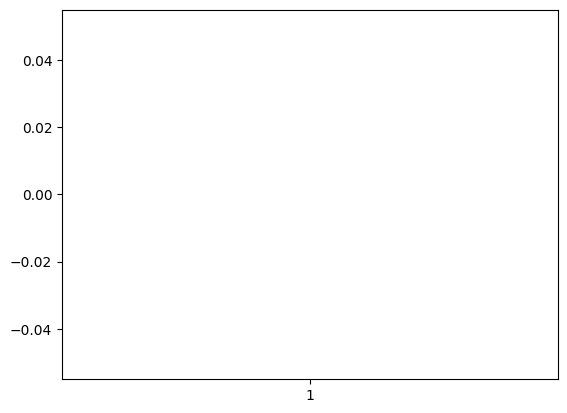

In [37]:
plt.boxplot(train_df['X_1'], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
plt.show()

### Feature Selection

모델링을 하기 앞서, 독립변수 X와 종속변수 y를 설정해야한다.

**학습에 사용할 변수 X와 예측할 변수 y를 분리**

In [20]:
train_y = train_df['Y_Class']
train_y

0      1
1      2
2      1
3      2
4      1
      ..
593    1
594    0
595    0
596    1
597    1
Name: Y_Class, Length: 598, dtype: int64

학습에 쓰이지 않을 column들을 제거한다.

In [22]:
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,timestamp
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


범주형 데이터를 수치 데이터로 전환하기 위해 LabelEncoder 활용

Done.


### Modeling

1.모델 선택 - sklearn라이브러리 활용 - RandomForest 

2.모델 학습 - train_df를 활용하여 1번에서 정의한 모델로 학습

3.예측 - 학습된 모델을 바탕으로 test 데이터를 예측

4.정답 파일 생성 - 정답 파일 생성 및 제출 필요(경진대회를 위해 필요한 과정.)

In [25]:
#모델 선언(모델 선택) + 모델 학습
#random_state=37 로 시드 고정.
RF = RandomForestClassifier(random_state=37, ).fit(train_x, train_y)
print('Done.')

Done.


In [26]:
#test 데이터로 예측
preds = RF.predict(test_x)
print('Done.')

Done.


In [27]:
#제출 파일에 예측 column 넣기
submission['Y_Class'] = preds
submission.to_csv('./baseline_submission2.csv', index=False)